# Sensor Modeling

# This tutorial demonstrates how to model sensor geometries.

# Setup

In [40]:
import sys

! {sys.executable} -m pip install --quiet numpy --upgrade
! {sys.executable} -m pip install --quiet plotly

# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryCorePy==0.1.9
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryMathematicsPy==0.1.5
# ! {sys.executable} -m pip install --quiet --index-url https://test.pypi.org/simple/ LibraryPhysicsPy==0.1.33

In [1]:
import numpy as np
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [2]:
import Library.Core as Core
import Library.Mathematics as Mathematics
import Library.Physics as Physics
import Library.Astrodynamics as Astrodynamics

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

to-Python converter for library::physics::time::DateTime already registered; second conversion method ignored.



In [97]:
Object2 = Mathematics.Geometry.D2.Object
Point2 = Mathematics.Geometry.D2.Objects.Point
LineString2 = Mathematics.Geometry.D2.Objects.LineString
Polygon2 = Mathematics.Geometry.D2.Objects.Polygon
Point3 = Mathematics.Geometry.D3.Objects.Point
Polygon3 = Mathematics.Geometry.D3.Objects.Polygon
Ellipsoid = Mathematics.Geometry.D3.Objects.Ellipsoid
Pyramid = Mathematics.Geometry.D3.Objects.Pyramid
Quaternion = Mathematics.Geometry.D3.Transformations.Rotations.Quaternion
RotationMatrix = Mathematics.Geometry.D3.Transformations.Rotations.RotationMatrix

Length = Physics.Units.Length
Angle = Physics.Units.Angle
Scale = Physics.Time.Scale
Instant = Physics.Time.Instant
Duration = Physics.Time.Duration
Interval = Physics.Time.Interval
DateTime = Physics.Time.DateTime
LLA = Physics.Coordinate.Spherical.LLA
AER = Physics.Coordinate.Spherical.AER
Position = Physics.Coordinate.Position
Velocity = Physics.Coordinate.Velocity
Frame = Physics.Coordinate.Frame
Transform = Physics.Coordinate.Transform
Environment = Physics.Environment
Geometry = Physics.Environment.Object.Geometry
Celestial = Physics.Environment.Objects.Celestial
Earth = Physics.Environment.Objects.CelestialBodies.Earth

Trajectory = Astrodynamics.Trajectory
Orbit = Astrodynamics.Trajectory.Orbit
State = Astrodynamics.Trajectory.State
Access = Astrodynamics.Access

In [202]:
Frame.Destruct("Body")

---

## Computation

### Environment

In [203]:
environment = Environment.Default()

In [204]:
earth = environment.accessCelestialObjectWithName("Earth")

In [205]:
earth_geometry = earth.getGeometryIn(Frame.ITRF())

### Satellite

Let's define the orbit of a satellite in LEO. In this example, we're modeling the orbit using SGP4.

In [206]:
a = Length.Kilometers(7000.0)
e = 0.0
i = Angle.Degrees(0.0)
raan = Angle.Degrees(0.0)
aop = Angle.Degrees(0.0)
nu = Angle.Degrees(0.0)

coe = Orbit.Models.Kepler.COE(a, e, i, raan, aop, nu)

In [207]:
epoch = Instant.DateTime(DateTime(2018, 9, 5, 0, 0, 0), Scale.UTC)
earth = Environment.Objects.CelestialBodies.Earth.Analytical(epoch)

keplerian_model = Orbit.Models.Kepler(coe, epoch, earth, Orbit.Models.Kepler.PerturbationType.No, True) # True = COE expressed in ITRF frame

In [208]:
keplerian_model.getClassicalOrbitalElements()

-- Classical Orbital Elements ----------------------------------------------------------------------
    Semi-major axis:                         7000000.0 [m]                            
    Eccentricity:                            1.3084304468063688e-16                   
    Inclination:                             0.10240766489087175 [deg]                
    Right ascension of the ascending node:   89.208817816846306 [deg]                 
    Argument of periapsis:                   0.0 [deg]                                
    True anomaly:                            254.60631958090099 [deg]                 
----------------------------------------------------------------------------------------------------

First, we need a **Two-Line Element** (TLE) set:

In [209]:
tle = Orbit.Models.SGP4.TLE("1 39419U 13066D   18248.44969859 -.00000394  00000-0 -31796-4 0  9997",
                            "2 39419  97.6313 314.6863 0012643 218.7350 141.2966 14.93878994260975")

To setup a **SGP4** orbital model:

In [210]:
sgp4_model = Orbit.Models.SGP4(tle)

We then obtain the satellite orbit (which is a trajectory):

In [246]:
# satellite_orbit = Orbit(keplerian_model, earth)
satellite_orbit = Orbit(sgp4_model, earth)

In [299]:
start_instant = Instant.DateTime(DateTime(2018, 9, 5, 0, 0, 0), Scale.UTC) ;
end_instant = Instant.DateTime(DateTime(2018, 9, 8, 0, 0, 0), Scale.UTC) ;

interval = Interval.Closed(start_instant, end_instant) ;

In [418]:
step = Duration.Minutes(1.0)

In [419]:
instants = interval.generateGrid(step)

In [420]:
states = [satellite_orbit.getStateAt(instant) for instant in instants]

In [421]:
states_lla = [LLA.Cartesian(state.inFrame(Frame.ITRF()).getPosition().getCoordinates(), Earth.EquatorialRadius, Earth.Flattening) for state in states]

In [422]:
states_line_string = LineString2([Point2(state_lla.getLongitude().inDegrees(), state_lla.getLatitude().inDegrees()) for state_lla in states_lla])

In [423]:
ground_track_df = pd.DataFrame([[float(state_lla.getLongitude().inDegrees()), float(state_lla.getLatitude().inDegrees())] for state_lla in states_lla], columns=['Longitude', 'Latitude']) ;

In [424]:
ground_track_df.head()

,Longitude,Latitude
0,-179.812102,75.073724
1,173.834291,71.786087
2,169.322630,68.361389
3,165.937137,64.854434
4,163.278708,61.294248


## Target

In [425]:
latitude = Angle.Degrees(0.0)
longitude = Angle.Degrees(0.0)
altitude = Length.Meters(10.0)

In [426]:
target_lla = LLA(latitude, longitude, altitude)

In [427]:
target_position = Position.Meters(target_lla.toCartesian(Earth.EquatorialRadius, Earth.Flattening), Frame.ITRF())

In [428]:
target_position

-- Position ----------------------------------------------------------------------------------------
    Coordinates:                             [6378146.3, 0.0, 0.0]                    
    Unit:                                    Meter                                    
    Frame:                                   ITRF                                     
----------------------------------------------------------------------------------------------------

### Sensor

In [429]:
orbital_frame = satellite_orbit.getOrbitalFrame(Orbit.FrameType.NED)
# orbital_frame = satellite_orbit.getOrbitalFrame(Orbit.FrameType.LVLH)

In [430]:
# body_frame_transform = Transform.Passive(Instant.J2000(), np.array((0.0, 0.0, 0.0)), np.array((0.0, 0.0, 0.0)), q_B_ITRF, np.array((0.0, 0.0, 0.0)))

# body_frame_provider = Frame.Providers.Static(body_frame_transform)

# body_frame = Frame.Construct("Body", False, orbital_frame, body_frame_provider)

In [431]:
def calculate_attitude (state, target):
    
    sensor_position_ITRF = state.inFrame(Frame.ITRF()).getPosition().getCoordinates()
    target_position_ITRF = target_position.getCoordinates()
    
    sensor_to_target_direction_ITRF = (target_position_ITRF - sensor_position_ITRF) / np.linalg.norm(target_position_ITRF - sensor_position_ITRF)
    
#     print(sensor_to_target_direction_ITRF)
    
    z_B_ITRF = sensor_to_target_direction_ITRF
    x_B_ITRF = np.cross(z_B_ITRF, np.array(((0.0), (1.0), (0.0))), axis=0)
    x_B_ITRF = x_B_ITRF / np.linalg.norm(x_B_ITRF)
    y_B_ITRF = np.cross(z_B_ITRF, x_B_ITRF, axis=0)
    
    dcm_B_ITRF = RotationMatrix.Rows(x_B_ITRF, y_B_ITRF, z_B_ITRF)
    q_B_ITRF = Quaternion.RotationMatrix(dcm_B_ITRF)
    
    q_ITRF_GCRF = Frame.GCRF().getTransformTo(Frame.ITRF(), state.getInstant()).getOrientation()
    
    q_B_GCRF = q_B_ITRF * q_ITRF_GCRF
    
#     print(q_B_GCRF.toString(Quaternion.Format.XYZS))
    
    return q_B_GCRF

In [432]:
def body_frame_transform_generator (instant):
    
    state = satellite_orbit.getStateAt(instant)
    
#     print(state)
    
    q_B_GCRF = calculate_attitude(state, target_position)
    
    return Transform.Passive(instant, -state.getPosition().getCoordinates(), np.array((0.0, 0.0, 0.0)), q_B_GCRF, np.array((0.0, 0.0, 0.0)))

body_frame_provider = Frame.Providers.Dynamic(body_frame_transform_generator)

Frame.Destruct("Body")

body_frame = Frame.Construct("Body", False, Frame.GCRF(), body_frame_provider)

In [433]:
# body_frame = orbital_frame

In [434]:
# print(body_frame.getTransformTo(Frame.GCRF(), start_instant))
# print(body_frame.getTransformTo(Frame.GCRF(), end_instant))

In [435]:
def calculate_intersection (target, state, frame, sensor):
    
#     state = tracking_state[0]
#     q_B_GCRF = tracking_state[1]

    target_lla = LLA.Cartesian(target.getCoordinates(), Earth.EquatorialRadius, Earth.Flattening)

    ned_frame = earth.getFrameAt(target_lla, Celestial.FrameType.NED)
    
    target_position_NED = target.inFrame(ned_frame, state.getInstant())
    satellite_position_NED = state.getPosition().inFrame(ned_frame, state.getInstant())

    aer = AER.FromPositionToPosition(target_position_NED, satellite_position_NED)
    
#     print(aer)
#     print(aer.getElevation().inDegrees())
    
    if aer.getElevation().inDegrees() < 70.0:
        
        return None
    
    observer_geometry_B = Geometry(sensor, frame)
    
#     print(observer_geometry_B)
    
    observer_geometry_ITRF = observer_geometry_B.inFrame(Frame.ITRF(), state.getInstant())
    
    intersection_ITRF = observer_geometry_ITRF.intersectionWith(earth_geometry)
    
#     print(intersection_ITRF)
    
    intersection_points = [Point2(lla.getLongitude().inDegrees(), lla.getLatitude().inDegrees()) for lla in [LLA.Cartesian(point_ITRF, Earth.EquatorialRadius, Earth.Flattening) for point_ITRF in intersection_ITRF.asLineString()]]

    intersection_polygon = Polygon2(intersection_points)
    
    return intersection_ITRF

In [436]:
apex_NED = Point3(0.0, 0.0, 0.0)
base_NED = Polygon3(Polygon2([Point2(-1.0, -1.0), Point2(+1.0, -1.0), Point2(+1.0, +1.0), Point2(-1.0, +1.0)]), apex_NED + np.array((0.0, 0.0, 1.0)), np.array((1.0, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)))

pyramid_NED = Pyramid(base_NED, apex_NED)

In [437]:
apex_LVLH = Point3(0.0, 0.0, 0.0)
base_LVLH = Polygon3(Polygon2([Point2(-1.0, -1.0), Point2(+1.0, -1.0), Point2(+1.0, +1.0), Point2(-1.0, +1.0)]), apex_LVLH - np.array((1.0, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)), np.array((0.0, 0.0, 1.0)))

pyramid_LVLH = Pyramid(base_LVLH, apex_LVLH)

In [438]:
apex_B = Point3(0.0, 0.0, 0.0)
base_B = Polygon3(Polygon2([Point2(-1.0, -1.0), Point2(+1.0, -1.0), Point2(+1.0, +1.0), Point2(-1.0, +1.0)]), apex_NED + np.array((0.0, 0.0, 1.0)), np.array((1.0, 0.0, 0.0)), np.array((0.0, 1.0, 0.0)))

pyramid_B = Pyramid(base_B, apex_B)

In [439]:
# pyramid = pyramid_NED
# pyramid = pyramid_LVLH
pyramid = pyramid_B

In [440]:
# tracking_states = [[state, calculate_attitude(state, target_position)] for state in states]

In [441]:
# tracking_states

In [442]:
# intersections_ITRF = [calculate_intersection(tracking_state, body_frame, pyramid) for tracking_state in tracking_states]
intersections_ITRF = [calculate_intersection(target_position, state, body_frame, pyramid) for state in states]

In [443]:
# intersections_ITRF

In [444]:
intersections_ITRF = [intersection_ITRF for intersection_ITRF in intersections_ITRF if intersection_ITRF is not None]

In [445]:
# intersections_ITRF

In [446]:
intersection_pointss = [[Point2(lla.getLongitude().inDegrees(), lla.getLatitude().inDegrees()) for lla in [LLA.Cartesian(point_ITRF, Earth.EquatorialRadius, Earth.Flattening) for point_ITRF in intersection_ITRF.asLineString()]] for intersection_ITRF in intersections_ITRF]

In [447]:
# intersection_pointss

In [448]:
intersection_dfs = [pd.DataFrame([[intersection_point.x(), intersection_point.y()] for intersection_point in intersection_points], columns=['Longitude', 'Latitude']) for intersection_points in intersection_pointss] ;

In [449]:
intersection_dfs[0].head()

,Longitude,Latitude
0,4.314179,4.261496
1,3.235546,4.330203
2,2.285867,4.401362
3,1.404349,4.476354
4,0.546298,4.557616


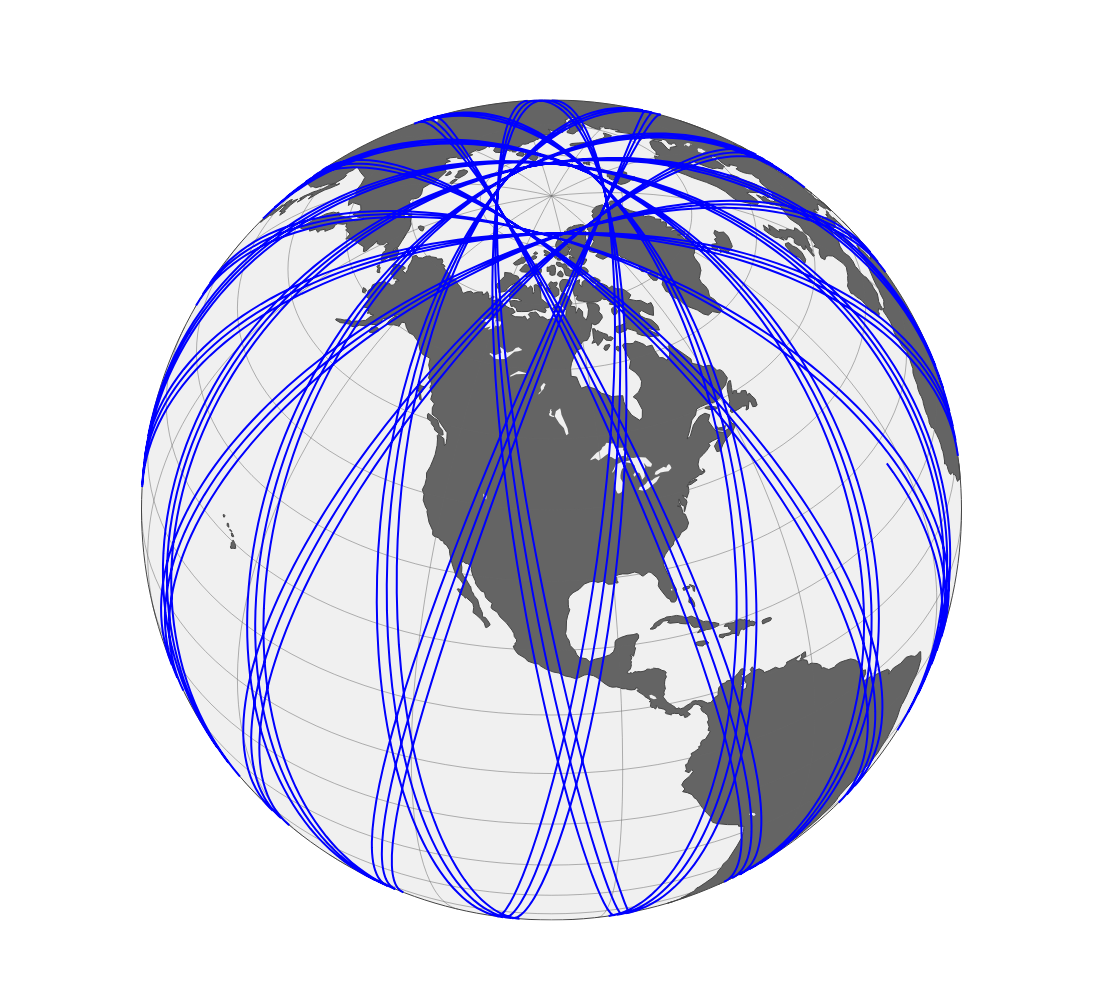

In [450]:
data = []

data.append( dict(
    type = 'scattergeo',
    lon = ground_track_df['Longitude'],
    lat = ground_track_df['Latitude'],
    mode = 'lines',
    line = dict(
        width = 2,
        color = 'blue'
    )
) )

[data.append(
    dict(
        type = 'scattergeo',
        lon = intersection_df['Longitude'],
        lat = intersection_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'red',
        )
    )
) for intersection_df in intersection_dfs]

layout = dict(
        title = None,
        showlegend = False,
        height=1000,
        geo = dict(
            showland = True,
            showlakes = True,
            showcountries = False,
            showocean = True,
            countrywidth = 0.0,
            landcolor = 'rgb(100, 100, 100)',
            lakecolor = 'rgb(240, 240, 240)',
            oceancolor = 'rgb(240, 240, 240)',
            projection = dict( 
                type = 'orthographic',
                rotation = dict(
                    lon = -100,
                    lat = 40,
                    roll = 0
                )            
            ),
            lonaxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            ),
            lataxis = dict( 
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)',
                gridwidth = 0.5
            )
        )
    )
    
fig = dict(data=data, layout=layout)

iplot(fig)

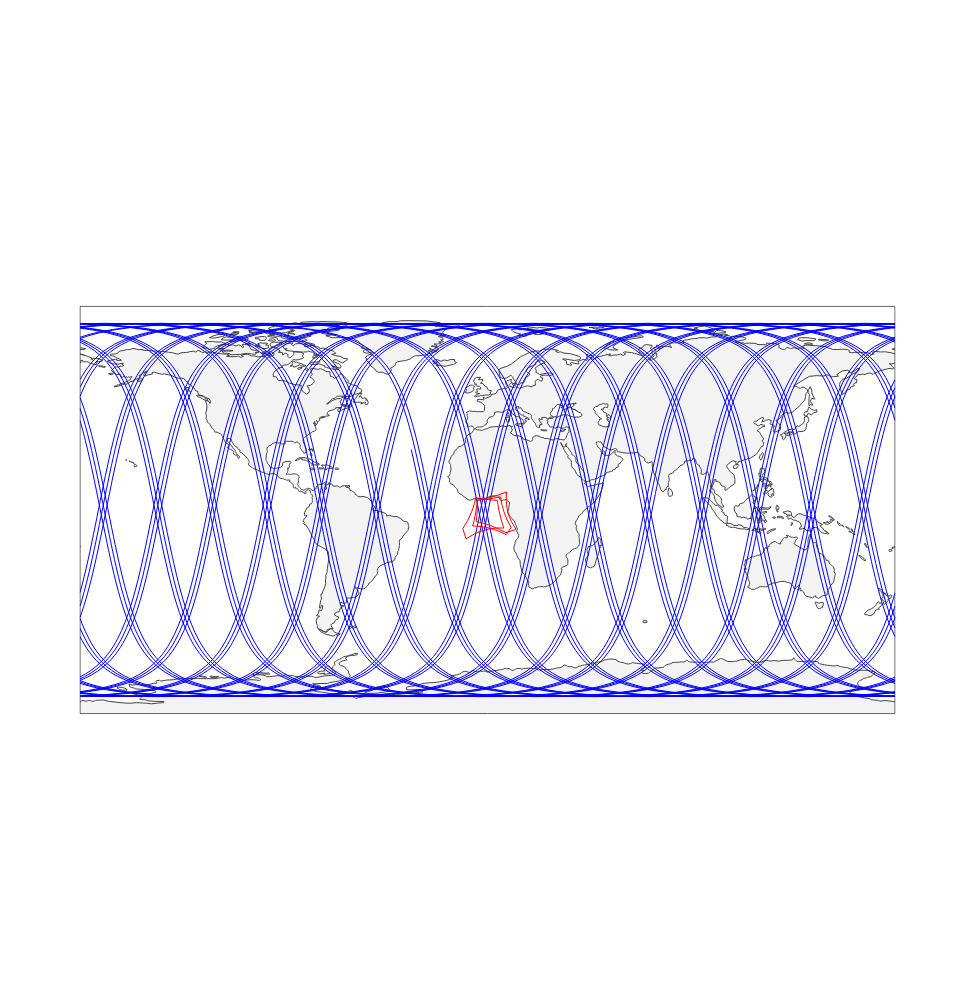

In [451]:
data = []

data.append(
    dict(
        type = 'scattergeo',
        lon = ground_track_df['Longitude'],
        lat = ground_track_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'blue',
        )
    )
)

[data.append(
    dict(
        type = 'scattergeo',
        lon = intersection_df['Longitude'],
        lat = intersection_df['Latitude'],
        mode = 'lines',
        line = dict(
            width = 1,
            color = 'red',
        )
    )
) for intersection_df in intersection_dfs]
    
layout = dict(
        title = None,
        showlegend = False,
        height=1000,
        geo = dict(
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
    )
    
fig = dict(data=data, layout=layout)
iplot(fig)